## Import Modules

In [1]:
import os, shutil, json, zipfile, random, math, urllib
from pathlib import Path
from PIL import Image
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("tensorflow version: ",tf.__version__)

2024-05-08 15:14:19.947694: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 15:14:19.947845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 15:14:20.169256: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tensorflow version:  2.15.0


Datasets Used -

https://www.kaggle.com/datasets/pcbreviglieri/pneumonia-xray-images

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

https://www.kaggle.com/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis

Kaggle Notebook - 

https://www.kaggle.com/code/darhan/chest-xray-pneumonia-normal-binary-classification


## Configure Plot

In [2]:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.subplot.wspace'] = 0.4
plt.rcParams['figure.subplot.hspace'] = 0.6
plt.rcParams['axes.titley'] = 1.0

## GPU Config

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
def gpu_config():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus: 
        tf.config.experimental.set_memory_growth(gpu, True)
    print(tf.config.list_physical_devices('GPU'))      

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    gpu_config()

[]


## Utils

In [5]:
def get_file_paths(folder_path):
    return [os.path.join(folder_path, file) for file in os.listdir(folder_path)]

def grid_plot(images_path_list):
    num_images = len(images_path_list)
    num_columns = 3
    num_rows = (num_images + num_columns - 1) // num_columns
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 4*num_rows))
    if num_rows == 1:
        axes = axes.reshape(1, -1)
    for i, image_path in enumerate(images_path_list):
        row = i // num_columns
        col = i % num_columns
        
        image = plt.imread(image_path)
        axes[row, col].imshow(image)
        folder_name = os.path.basename(os.path.dirname(image_path))
        image_name = os.path.basename(image_path)
        axes[row, col].set_title(folder_name + '/' + image_name)
        axes[row, col].axis('on')
        
    plt.tight_layout()
    plt.show()
    
def delete_files_and_folders(folder_path):
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        
        if os.path.isfile(item_path):
            os.unlink(item_path)
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)

    print("All files and folders inside", folder_path, "have been deleted.")
    print(os.listdir(folder_path))
    
def get_directory_size(directory):
    """
    Returns the size of the directory in bytes.
    """
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        for f in filenames:
            file_path = os.path.join(dirpath, f)
            total_size += os.path.getsize(file_path)
    return total_size

def print_subfolders(root_folder):
    for entry in os.scandir(root_folder):
        if entry.is_dir():
            full_path = os.path.join(root_folder, entry.name)
            print(full_path, len(os.listdir(full_path)))
            print_subfolders(full_path)

def convert_bytes(size):
    for unit in ['', 'K', 'M', 'G', 'T', 'P']:
        if size < 1024:
            return f"{size:.2f} {unit}B"
        size /= 1024
        
def create_directory(directories):
    for directory in directories:
        if not os.path.exists(directory):
            os.mkdir(directory)
            print('Created {}'.format(directory))
        else:
            print('{} exists'.format(directory))
            
def copy_images(images_list, to_dir):
    if not os.path.exists(to_dir):
        os.mkdir(to_dir)
    
    for image_path in images_list:
        image_name = os.path.basename(image_path)
        destination_path = os.path.join(to_dir, image_name)
        shutil.copy(image_path, destination_path)
    
    print("Images copied successfully to", to_dir, len(os.listdir(to_dir)))
    
def move_images(images_list, to_dir):
    if not os.path.exists(to_dir):
        os.mkdir(to_dir)
    
    for image_path in images_list:
        image_name = os.path.basename(image_path)
        destination_path = os.path.join(to_dir, image_name)
        shutil.move(image_path, destination_path)
    
    print("Images moved successfully to", to_dir, len(os.listdir(to_dir)))
    
def move(from_dir, start, end, to_dir):
    images = os.listdir(from_dir)[start:end]
    images_paths = [os.path.join(from_dir, image) for image in images]
    move_images(images_paths, to_dir) 
    print(len(os.listdir(to_dir)))
    
def copy(from_dir, start, end, to_dir):
    images = os.listdir(from_dir)[start:end]
    images_paths = [os.path.join(from_dir, image) for image in images]
    copy_images(images_paths, to_dir) 
    print(len(os.listdir(to_dir)))
    
def data_info(directory):
    images = os.listdir(directory)
    print(f"Images in {os.path.basename(directory)} : {len(images)}")
    extensions = [os.path.splitext(file)[1] for file in images]
    unique_extensions = set(extensions)
    print("Images are present in these extensions:", unique_extensions)
    
def check_image_readability(folder_path):
    file_list = os.listdir(folder_path)
    
    errored_images = []
    correct_images = []

    for file_name in file_list:
        file_path = os.path.join(folder_path, file_name)
        try:
            with Image.open(file_path) as img:
                img.load()
            correct_images.append(file_path)
        except Exception as e:
            print(e)
            print(file_path)
            errored_images.append(file_path)
            continue
    
    if errored_images:
        print("There are errored images")
    else:
        print("All images are readable.")
    return errored_images, correct_images

def remove_images(images_list):
    if images_list:
        for image in images_list:
            os.remove(image)
        print(len(images_list),'removed')
    else:
        pass

## Create Folders

In [12]:
working_dir = os.getcwd()
dataset = os.path.join(working_dir, 'dataset')

logs_dir = os.path.join(os.getcwd(), 'logs')
models_dir = os.path.join(os.getcwd(), 'models')
hist_dir = os.path.join(os.getcwd(), 'history')
figures_dir = os.path.join(os.getcwd(), 'figures')
zipfiles_dir = os.path.join(os.getcwd(), 'zipfiles')
train_dir = os.path.join(os.getcwd(), 'train')
test_dir = os.path.join(os.getcwd(), 'test')
val_dir = os.path.join(os.getcwd(), 'val')

create_directory([logs_dir, models_dir, hist_dir, figures_dir, zipfiles_dir,train_dir,test_dir,val_dir])

/kaggle/working/logs exists
/kaggle/working/models exists
/kaggle/working/history exists
/kaggle/working/figures exists
/kaggle/working/zipfiles exists
/kaggle/working/train exists
/kaggle/working/test exists
/kaggle/working/val exists


In [60]:
delete_files_and_folders(models_dir)
delete_files_and_folders(train_dir)
delete_files_and_folders(test_dir)
delete_files_and_folders(val_dir)

# delete_files_and_folders(hist_dir)
# delete_files_and_folders(logs_dir)
# delete_files_and_folders(figures_dir)
# delete_files_and_folders(zipfiles_dir)
# delete_files_and_folders(os.getcwd())

All files and folders inside /kaggle/working/models have been deleted.
[]
All files and folders inside /kaggle/working/train have been deleted.
[]
All files and folders inside /kaggle/working/test have been deleted.
[]
All files and folders inside /kaggle/working/val have been deleted.
[]


## Assign Paths to Dataset folders

In [29]:
dataset_dir_1 = '/kaggle/input/chest-xray-pneumonia'
dataset_dir_2 = '/kaggle/input/pneumonia-xray-images'
dataset_dir_3 = '/kaggle/input/chest-xray-pneumoniacovid19tuberculosis'


project_name = 'Chest-XRay-Pneumonia'+'_'

## Exploratory Analysis

## Get Dataset Info

In [9]:
dataset_dir = dataset_dir_1

print(dataset_dir,'\n')
print(project_name,'\n')

print_subfolders(dataset_dir)

size_in_bytes = get_directory_size(dataset_dir)
readable_size = convert_bytes(size_in_bytes)
print(f"\nDirectory size of {dataset_dir}: {readable_size}\n")

/kaggle/input/chest-xray-pneumonia 

Chest-XRay-Pneumonia_ 

/kaggle/input/chest-xray-pneumonia/chest_xray 5
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray 4
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val 3
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA 9
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL 9
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test 3
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA 390
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL 234
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train 3
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA 3876
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL 1342
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX 2
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray 6
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val 

#### Directory size of /kaggle/input/chest-xray-pneumonia: 2.31 GB

In [10]:
dataset_dir = dataset_dir_2

print(dataset_dir,'\n')
print(project_name,'\n')

print_subfolders(dataset_dir)

size_in_bytes = get_directory_size(dataset_dir)
readable_size = convert_bytes(size_in_bytes)
print(f"\nDirectory size of {dataset_dir}: {readable_size}\n")

/kaggle/input/pneumonia-xray-images 

Chest-XRay-Pneumonia_ 

/kaggle/input/pneumonia-xray-images/val 2
/kaggle/input/pneumonia-xray-images/val/normal 267
/kaggle/input/pneumonia-xray-images/val/opacity 773
/kaggle/input/pneumonia-xray-images/test 2
/kaggle/input/pneumonia-xray-images/test/normal 234
/kaggle/input/pneumonia-xray-images/test/opacity 390
/kaggle/input/pneumonia-xray-images/train 2
/kaggle/input/pneumonia-xray-images/train/normal 1082
/kaggle/input/pneumonia-xray-images/train/opacity 3110

Directory size of /kaggle/input/pneumonia-xray-images: 1.15 GB



#### Directory size of /kaggle/input/pneumonia-xray-images: 1.15 GB

In [11]:
dataset_dir = dataset_dir_3

print(dataset_dir,'\n')
print(project_name,'\n')

print_subfolders(dataset_dir)

size_in_bytes = get_directory_size(dataset_dir)
readable_size = convert_bytes(size_in_bytes)
print(f"\nDirectory size of {dataset_dir}: {readable_size}\n")

/kaggle/input/chest-xray-pneumoniacovid19tuberculosis 

Chest-XRay-Pneumonia_ 

/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/val 4
/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/val/PNEUMONIA 8
/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/val/NORMAL 8
/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/val/COVID19 10
/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/val/TURBERCULOSIS 12
/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/test 4
/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/test/PNEUMONIA 390
/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/test/NORMAL 234
/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/test/COVID19 106
/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/test/TURBERCULOSIS 41
/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/train 4
/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/train/PNEUMONIA 3875
/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/train/NORMAL 1341
/kaggle/input/chest

#### Directory size of /kaggle/input/chest-xray-pneumoniacovid19tuberculosis: 1.79 GB

## Move Images to Working

In [62]:
pneumonia_folders = ['/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/train/PNEUMONIA', '/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/test/PNEUMONIA', '/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/val/PNEUMONIA', '/kaggle/input/pneumonia-xray-images/train/opacity', '/kaggle/input/pneumonia-xray-images/test/opacity' ,'/kaggle/input/pneumonia-xray-images/val/opacity', '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA', '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA']

In [47]:
pneumonia_images = []
for folder in pneumonia_folders:
    images = get_file_paths(folder)
    pneumonia_images += images
        
len(pneumonia_images)

12812

#### Total 12812 pneumonia images from all datasets 

In [46]:
normal_folders = ['/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/train/NORMAL', '/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/test/NORMAL', '/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/val/NORMAL', '/kaggle/input/pneumonia-xray-images/train/normal', '/kaggle/input/pneumonia-xray-images/test/normal', '/kaggle/input/pneumonia-xray-images/val/normal', '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL', '/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL', '/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL']

In [48]:
normal_images = []
for folder in normal_folders:
    images = get_file_paths(folder)
    normal_images += images
        
len(normal_images)

4749

#### Total 4749 normal images from all datasets 

### Train

In [67]:
to_dir = train_dir+'/'+'normal'
copy_images(normal_images[:], to_dir)

Images copied successfully to /kaggle/working/train/normal 1583


In [68]:
to_dir = train_dir+'/'+'pneumonia'
copy_images(pneumonia_images[:], to_dir)

Images copied successfully to /kaggle/working/train/pneumonia 4274


#### Due to same images used in three datasets, after moving to working dir only 1583 normal and 4274 pneumonia images were available

### Test

In [69]:
from_dir = '/kaggle/working/train/normal'
to_dir = test_dir+'/'+'normal'
move(from_dir, 0, 100, to_dir)

Images moved successfully to /kaggle/working/test/normal 100
100


In [70]:
from_dir = '/kaggle/working/train/pneumonia'
to_dir = test_dir+'/'+'pneumonia'
move(from_dir, 0, 100, to_dir)

Images moved successfully to /kaggle/working/test/pneumonia 100
100


In [71]:
images_paths = get_file_paths('/kaggle/working/train/pneumonia')

remove_images(images_paths[0:2691])

2691 removed


#### Keep 2966 images for training(1483 images each), 200 images as unseen data(100 each) 

## Assign paths after moving images

In [9]:
root_dir = '/kaggle/working/train/'

class_1 = '/kaggle/working/train/normal'
class_2 = '/kaggle/working/train/pneumonia'

test_dir_1 = '/kaggle/working/test/normal'
test_dir_2 = '/kaggle/working/test/pneumonia'

    train/
    ...normal/
    ......a_image_1.jpg
    ......a_image_2.jpg
    ...pneumonia/
    ......b_image_1.jpg
    ......b_image_2.jpg

    test/
    ...normal/
    ......a_image_1.jpg
    ......a_image_2.jpg
    ...pneumonia/
    ......b_image_1.jpg
    ......b_image_2.jpg

## Get Train Data info and Readability

In [73]:
data_info(class_1)
data_info(class_2)

errored_images_1, correct_images_1 = check_image_readability(class_1)
print(len(errored_images_1), len(correct_images_1))

errored_images_2, correct_images_2 = check_image_readability(class_2)
print(len(errored_images_2), len(correct_images_2))

Images in normal : 1483
Images are present in these extensions: {'.jpeg'}
Images in pneumonia : 1483
Images are present in these extensions: {'', '.jpeg'}
All images are readable.
0 1483
cannot identify image file '/kaggle/working/train/pneumonia/.DS_Store'
/kaggle/working/train/pneumonia/.DS_Store
There are errored images
1 1482


In [74]:
remove_images(errored_images_1)
remove_images(errored_images_2)

1 removed


In [75]:
data_info(test_dir_1)
data_info(test_dir_2)

Images in normal : 100
Images are present in these extensions: {'.jpeg'}
Images in pneumonia : 100
Images are present in these extensions: {'.jpeg'}


In [76]:
errored_images_1_test, correct_images_1_test = check_image_readability(test_dir_1)
print(len(errored_images_1_test), len(correct_images_1_test))

errored_images_2_test, correct_images_2_test = check_image_readability(test_dir_2)
print(len(errored_images_2_test), len(correct_images_2_test))

All images are readable.
0 100
All images are readable.
0 100


## Plot Distribution of Images

Chest-XRay-Pneumonia_ Distribution of Images saved to /kaggle/working/figures


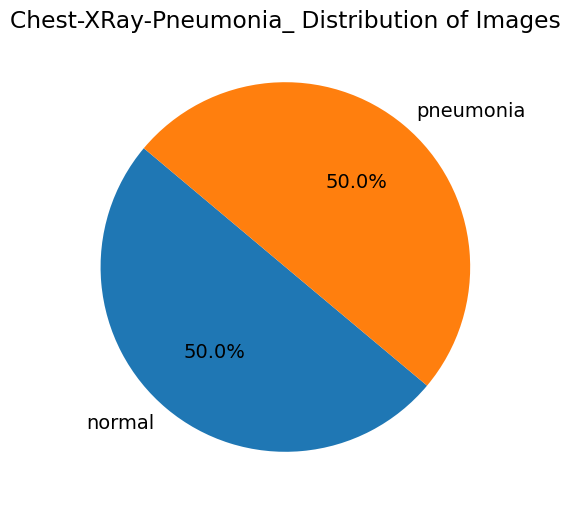

In [77]:
labels = [os.path.basename(class_1), os.path.basename(class_2)]
sizes = [len(os.listdir(class_1)), len(os.listdir(class_2))]
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
title = '{} Distribution of Images'.format(project_name)
plt.title(title)
plt.savefig(figures_dir+'/'+title+'.png')
print('{} saved to {}'.format(title, figures_dir))
plt.show()

## Plot Images in Grid

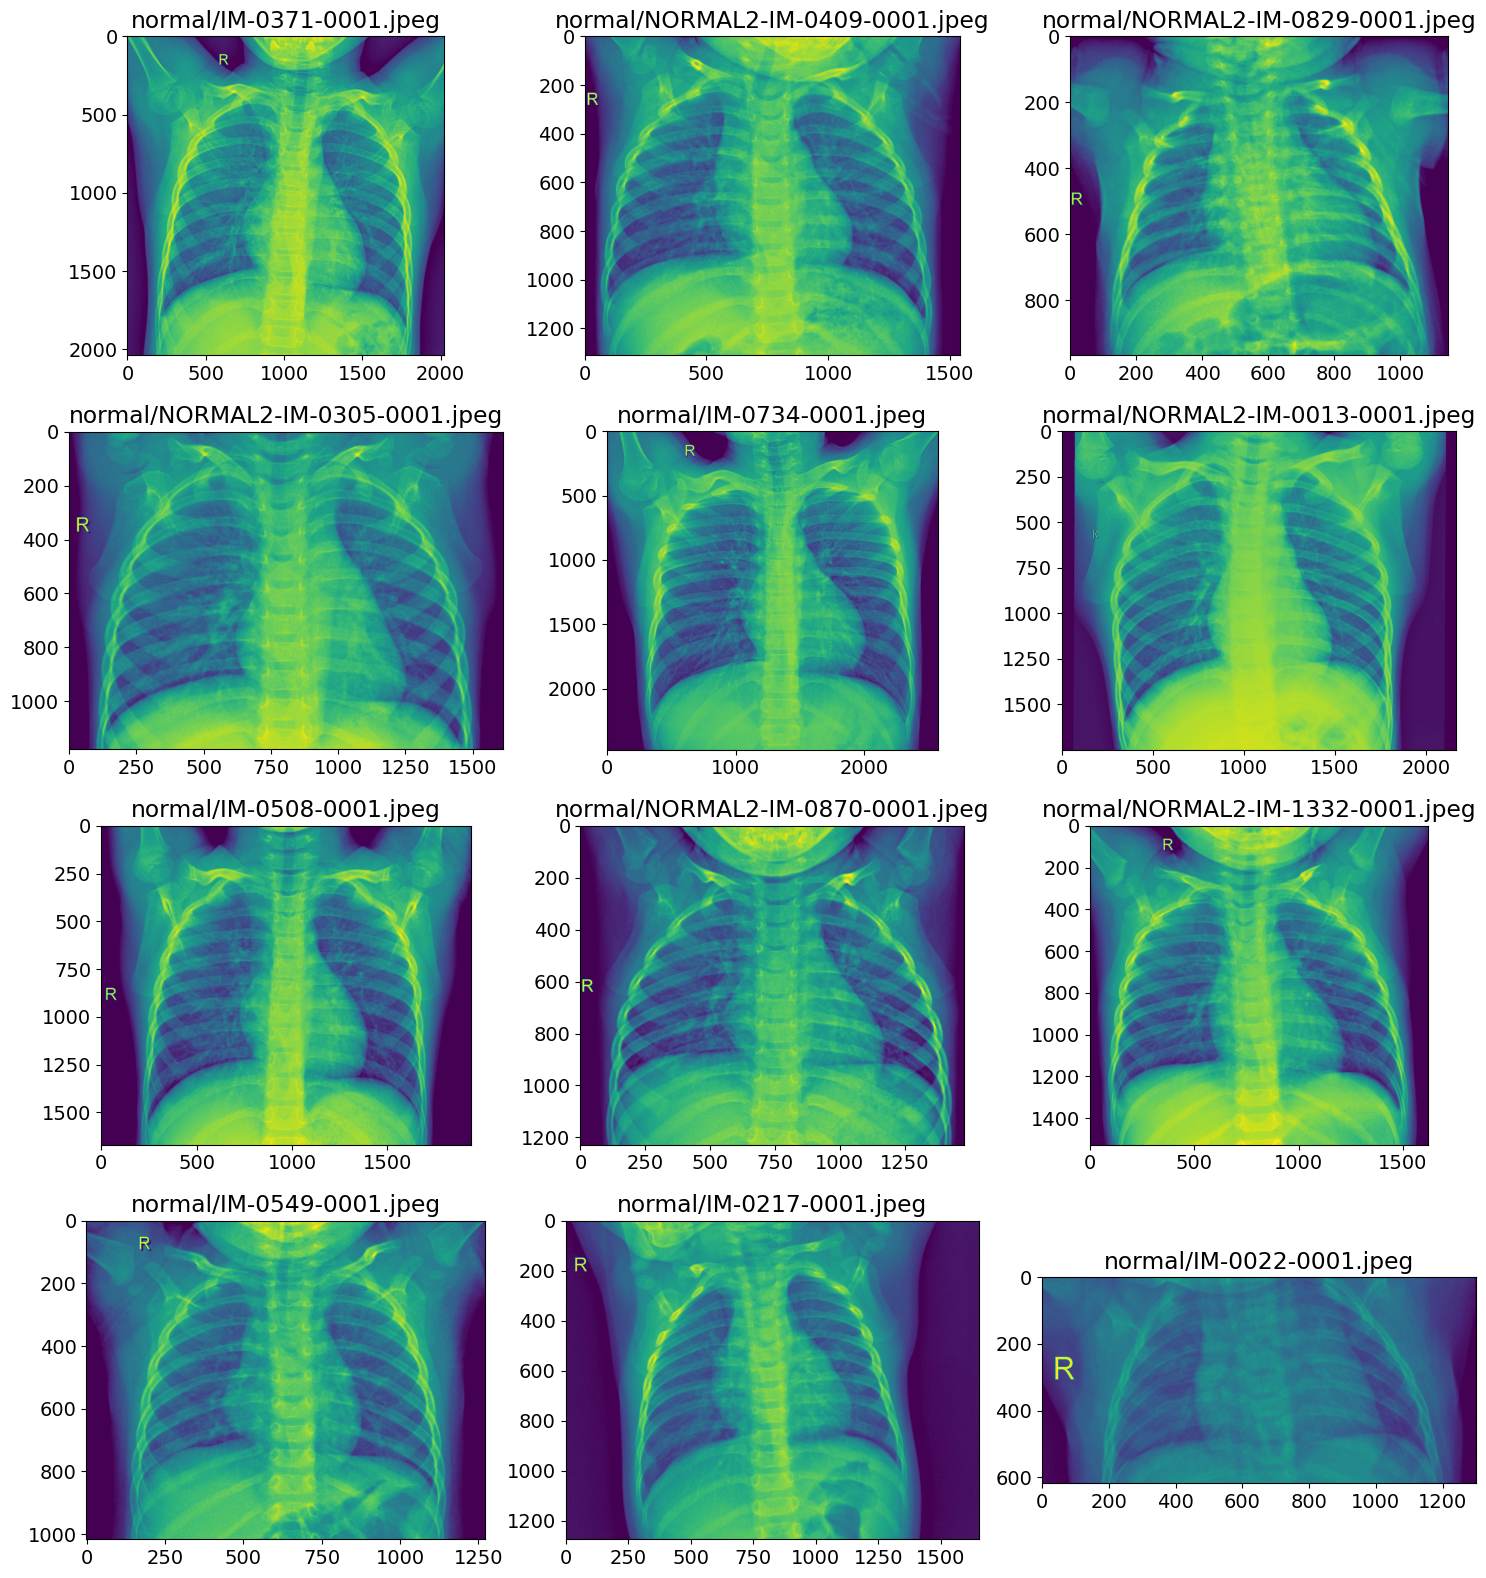

In [78]:
grid_plot(correct_images_1[:12])

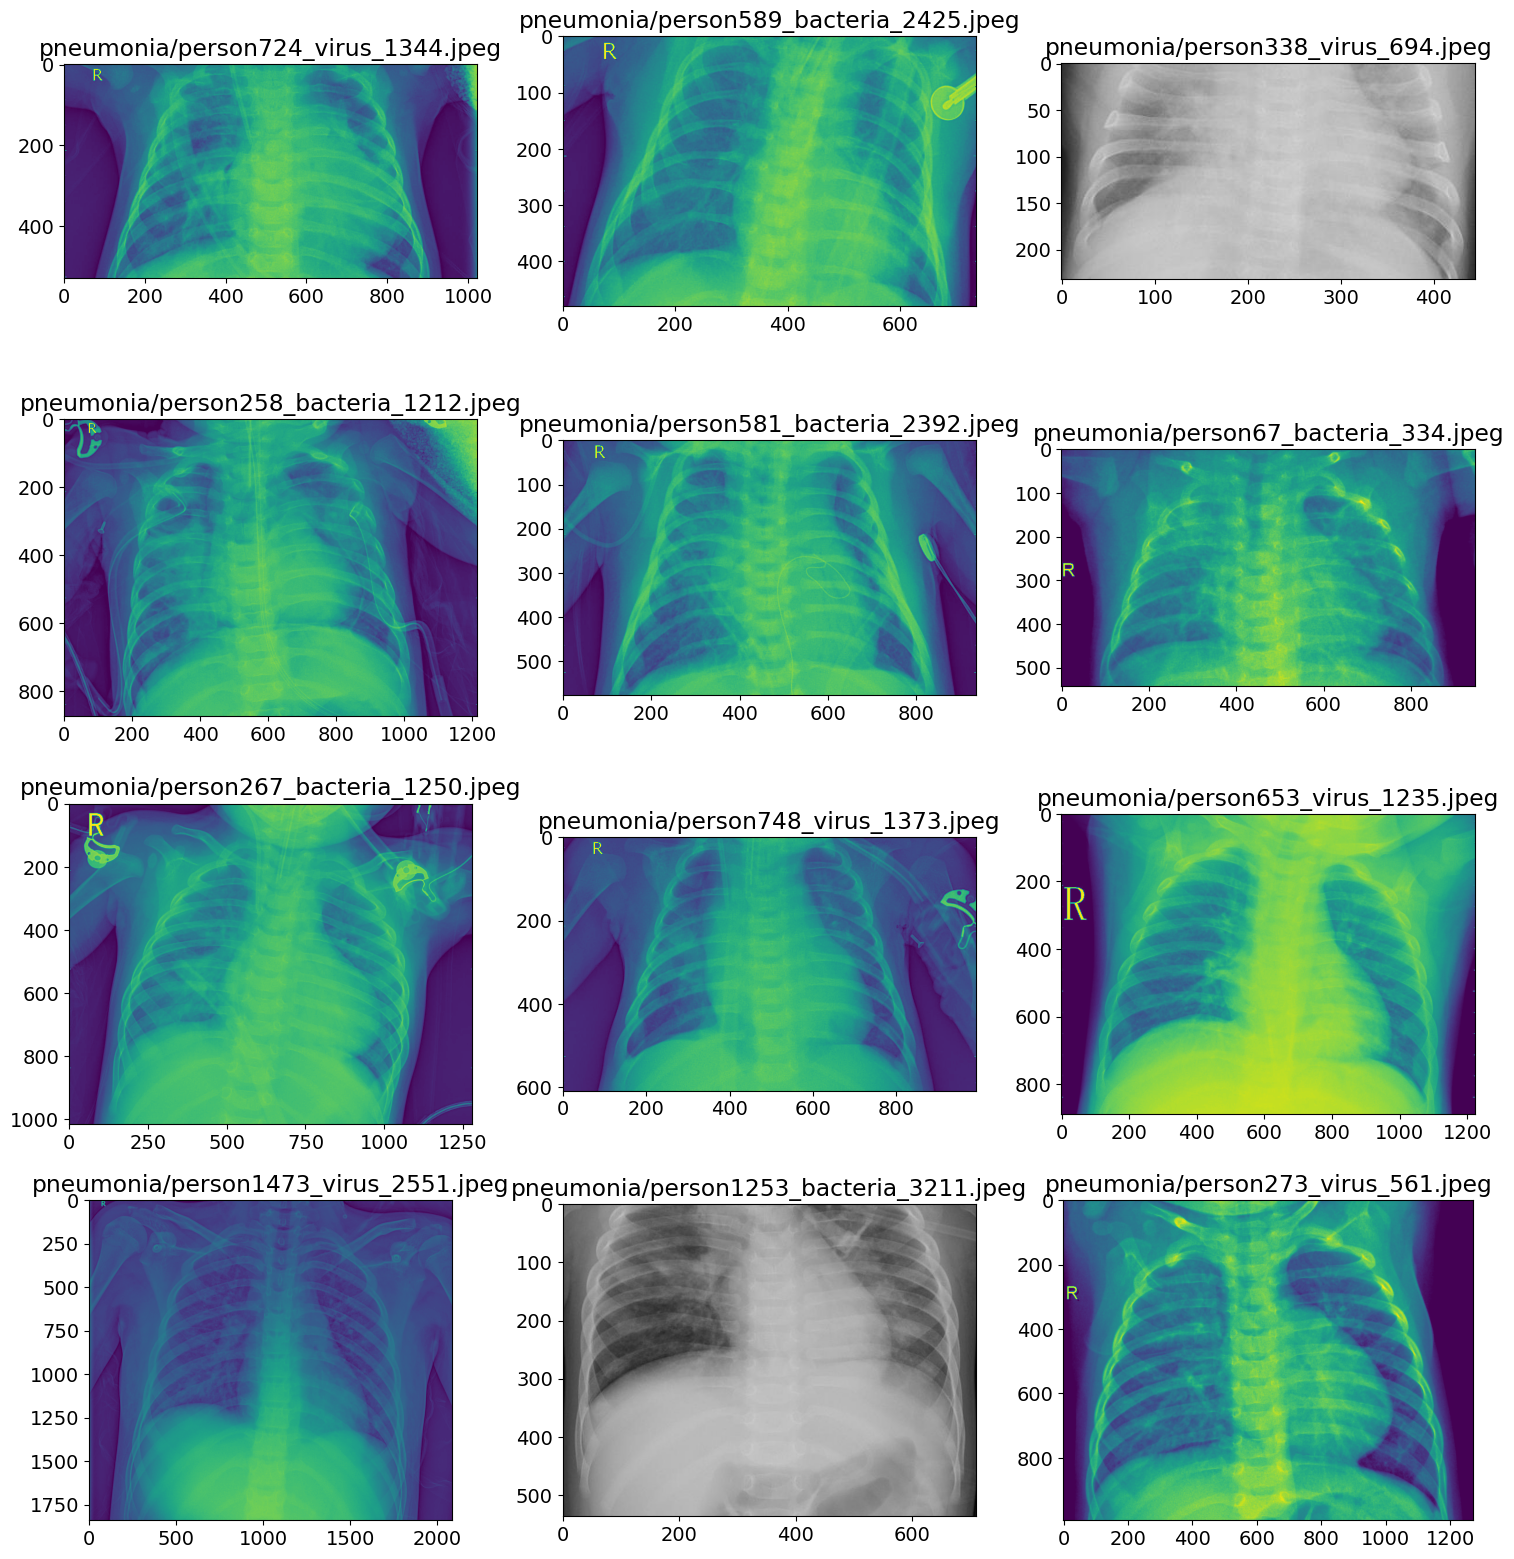

In [79]:
grid_plot(correct_images_2[:12])

## Preprocessing

In [6]:
tf.keras.utils.image_dataset_from_directory

<function keras.src.utils.image_dataset_utils.image_dataset_from_directory(directory, labels='inferred', label_mode='int', class_names=None, color_mode='rgb', batch_size=32, image_size=(256, 256), shuffle=True, seed=None, validation_split=None, subset=None, interpolation='bilinear', follow_links=False, crop_to_aspect_ratio=False, pad_to_aspect_ratio=False, data_format=None, verbose=True)>

Generates a tf.data.Dataset from image files in a directory that yields batches of images from the subdirectories class_a and class_b, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b).

        tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',
        class_names=None,
        color_mode='rgb',
        batch_size=32,
        image_size=(256, 256),
        shuffle=True,
        seed=None,
        validation_split=None,
        subset=None,
        interpolation='bilinear',
        follow_links=False,
        crop_to_aspect_ratio=False,
        pad_to_aspect_ratio=False,
        data_format=None,
        verbose=True
        )

        train/
        ...normal/
        ......a_image_1.jpg
        ......a_image_2.jpg
        ...pneumonia/
        ......b_image_1.jpg
        ......b_image_2.jpg

        test/
        ...normal/
        ......a_image_1.jpg
        ......a_image_2.jpg
        ...pneumonia/
        ......b_image_1.jpg
        ......b_image_2.jpg

### Load Data

In [7]:
input_shape = (150, 150, 3)

In [10]:
data = tf.keras.utils.image_dataset_from_directory(root_dir, image_size=(input_shape[0], input_shape[1]))
total_images_train = len(data.file_paths)
print('{} Images loaded'.format(total_images_train))

Found 2965 files belonging to 2 classes.
2965 Images loaded


In [13]:
test_data = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=(input_shape[0], input_shape[1]))
total_images_test = len(test_data.file_paths)
print('{} Images loaded'.format(total_images_test))

Found 200 files belonging to 2 classes.
200 Images loaded


### Check class labels

In [14]:
class_labels = {}
print('Classes found {}'.format(data.class_names))
for idx, class_name in enumerate(data.class_names):
    print(f"Class Label: {idx}, Class Name: {class_name}")
    class_labels[class_name] = idx
print(class_labels,'\n')

print('Type of Data : ',type(data),'\n')
print('Number of batches : ',len(data),'\n')
print(data.element_spec)

Classes found ['normal', 'pneumonia']
Class Label: 0, Class Name: normal
Class Label: 1, Class Name: pneumonia
{'normal': 0, 'pneumonia': 1} 

Type of Data :  <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'> 

Number of batches :  93 

(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


When you load data using tf.keras.utils.image_dataset_from_directory, it automatically batches the data according to the specified batch_size. Since you didn't specify the batch_size in your code, it defaulted to 32. Therefore, the total number of batches is calculated as:

Total number of batches = Total number of images / Batch size

In this case:
Batch size = 32

So, the total number of batches = Total number of images / 32 = batches

92 batches with 32 images , 93rd batch with 21 remaining images

### Grid Plot for a batch of preprocessed images

In [15]:
data_iterator = data.as_numpy_iterator()
print(type(data_iterator))

<class 'tensorflow.python.data.ops.dataset_ops.NumpyIterator'>


Take a batch to plot the images

In [16]:
batch = data_iterator.next()

In [17]:
print("Type of batch:", type(batch))
print("Length of batch:", len(batch))
print("Shape of batch[0] (Images):", batch[0].shape)
print("Shape of batch[1] (Labels):", batch[1].shape)
print("Type of batch[0] (Images):", type(batch[0]))
print("Type of batch[1] (Labels):", type(batch[1]))
print("Minimum value in batch[0]:", batch[0].min())
print("Maximum value in batch[0]:", batch[0].max())

Type of batch: <class 'tuple'>
Length of batch: 2
Shape of batch[0] (Images): (32, 150, 150, 3)
Shape of batch[1] (Labels): (32,)
Type of batch[0] (Images): <class 'numpy.ndarray'>
Type of batch[1] (Labels): <class 'numpy.ndarray'>
Minimum value in batch[0]: 0.0
Maximum value in batch[0]: 255.0


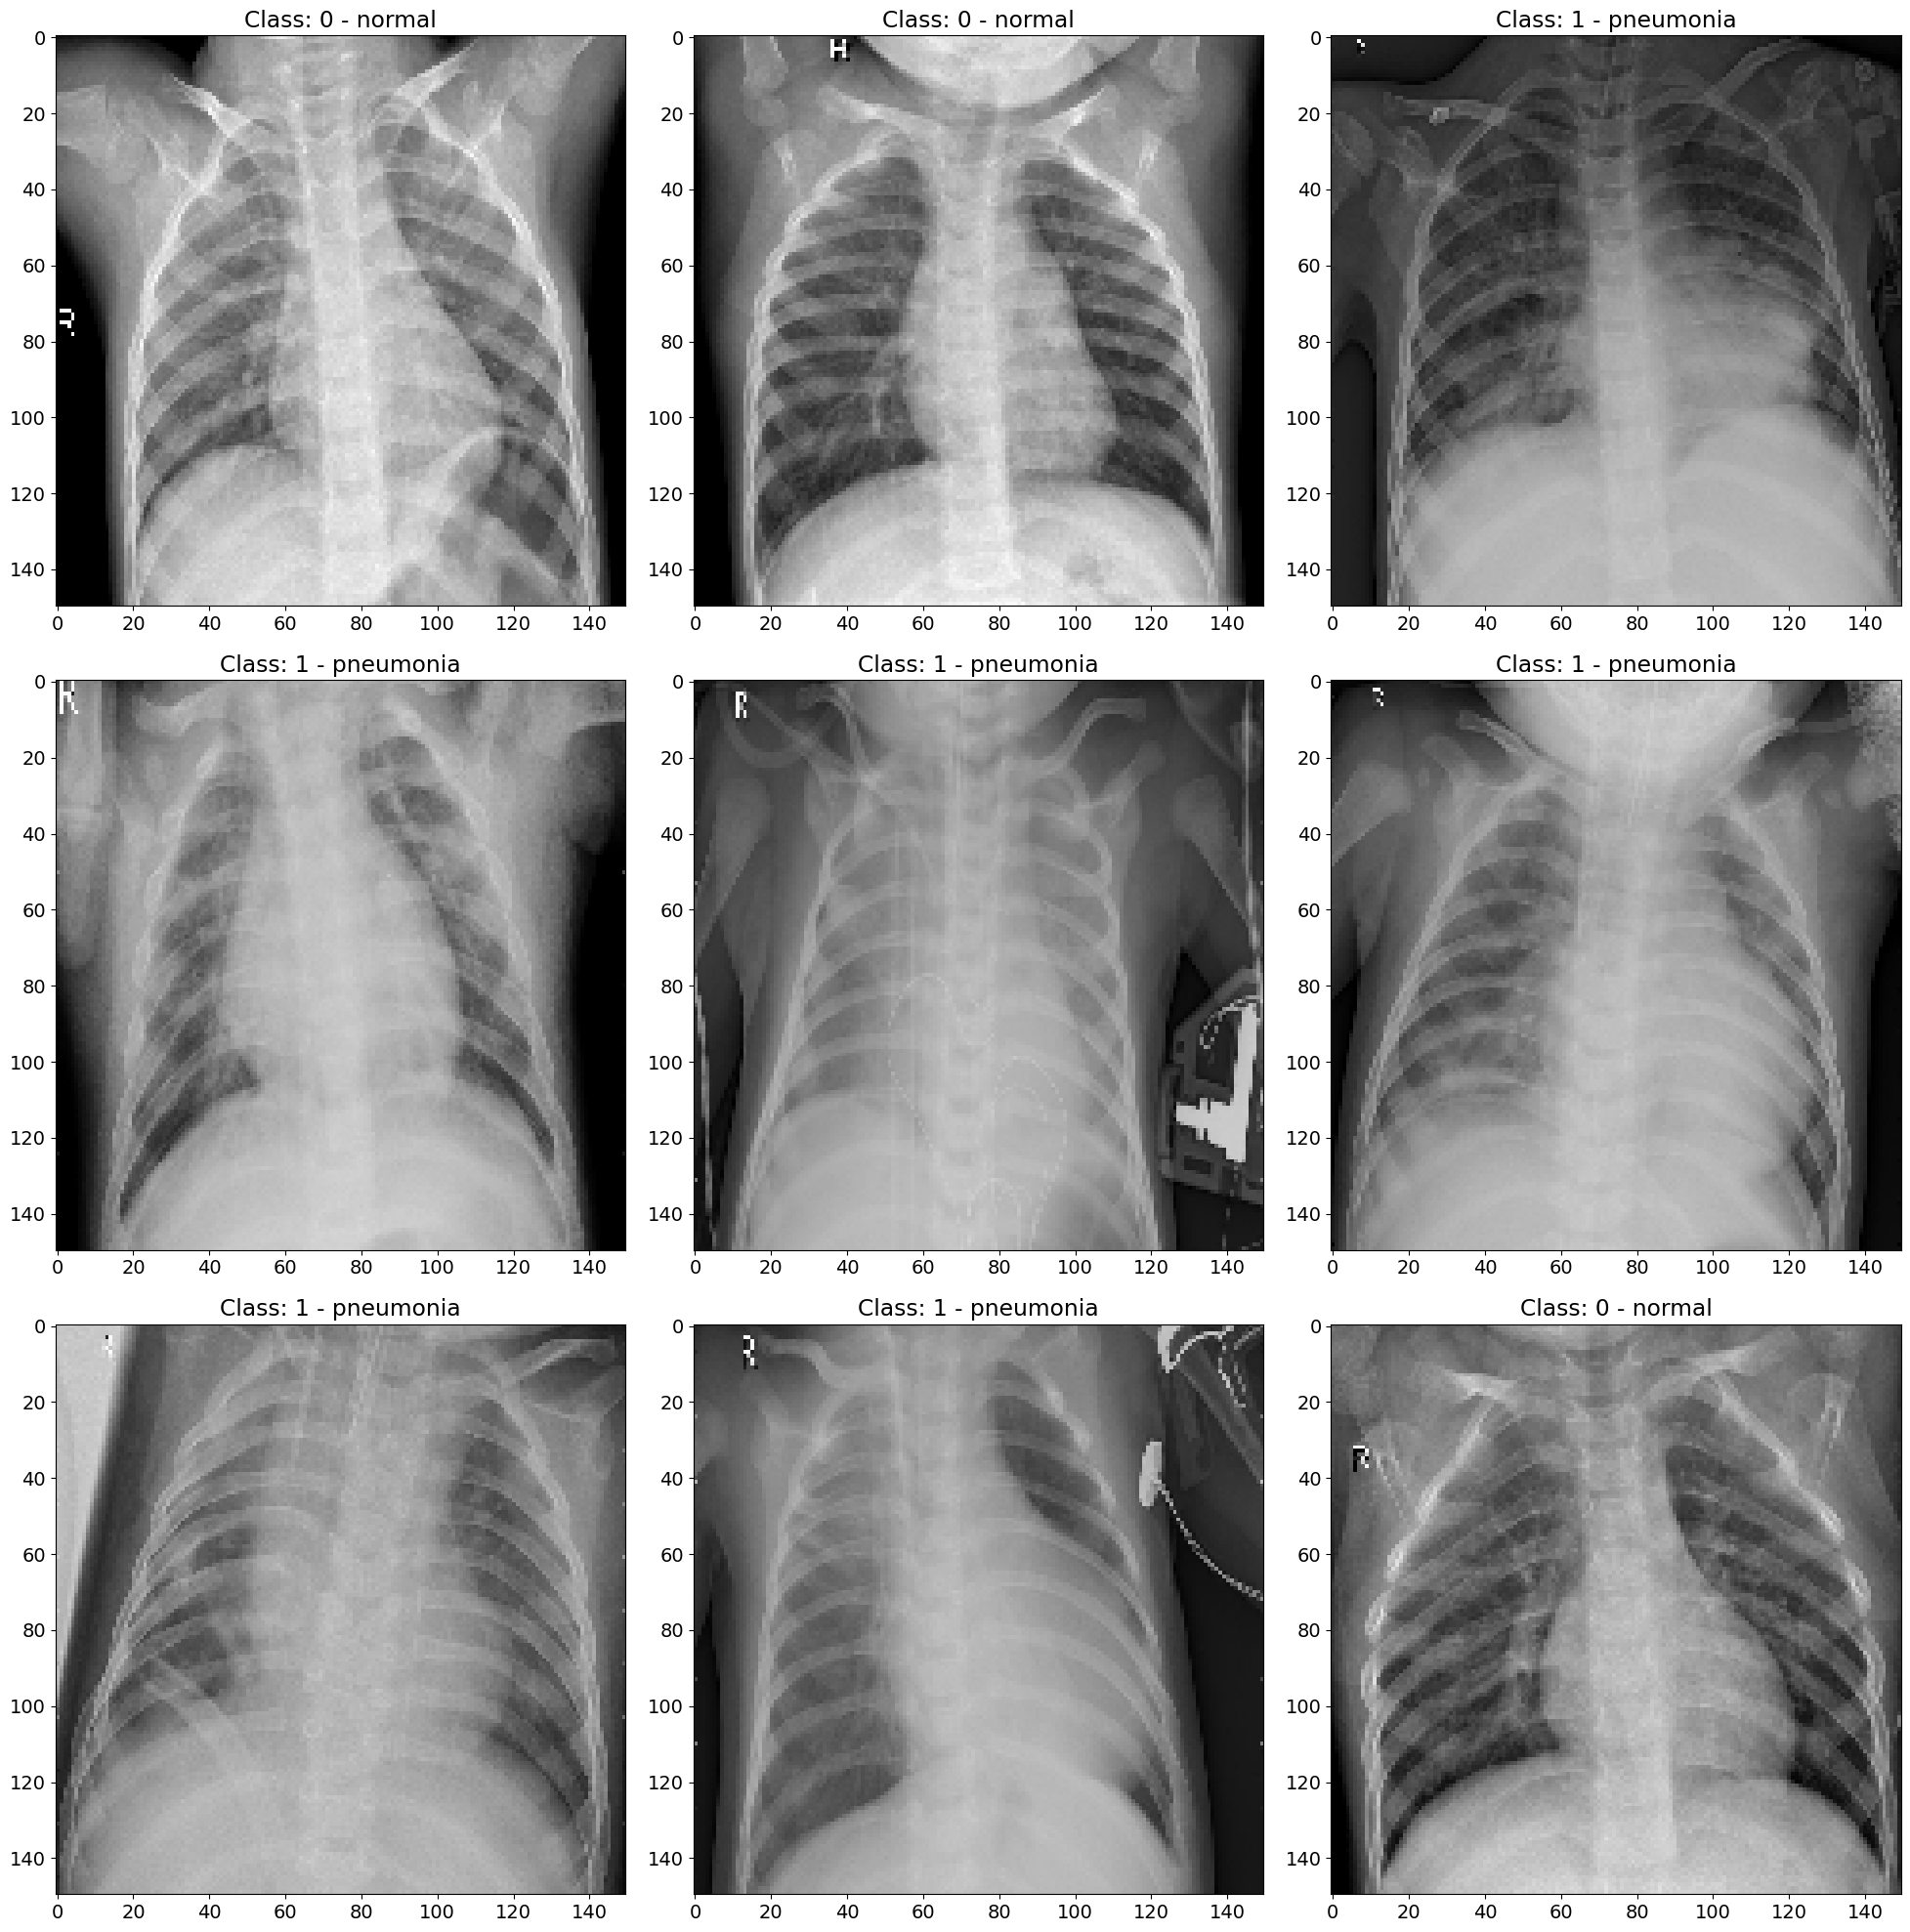

In [88]:
grid_shape = (3, 3)
total_images = 9
num_rows =3
num_cols = 3

fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 20))
for idx, img in enumerate(batch[0][:total_images]):
    row = idx // grid_shape[1]  
    col = idx % grid_shape[1]  
    ax[row, col].imshow(img.astype(int))
    class_label = batch[1][idx]
    class_name = data.class_names[class_label]
    ax[row, col].title.set_text(f"Class: {class_label} - {class_name}")

plt.tight_layout()
plt.show()

### Normalize images from 0-255 to 0-1

In [18]:
scaled_data = data.map(lambda x,y: (x/255, y))
scaled_test_data = test_data.map(lambda x,y: (x/255, y))

In [19]:
print(type(scaled_data), len(scaled_data))

<class 'tensorflow.python.data.ops.map_op._MapDataset'> 93


In [20]:
scaled_batch = scaled_data.as_numpy_iterator().next()

In [21]:
print("Type of scaled_batch:", type(scaled_batch))
print("Length of scaled_batch:", len(scaled_batch))
print("Shape of scaled_batch[0] (Images):", scaled_batch[0].shape)
print("Shape of scaled_batch[1] (Labels):", scaled_batch[1].shape)
print("Type of scaled_batch[0] (Images):", type(scaled_batch[0]))
print("Type of scaled_batch[1] (Labels):", type(scaled_batch[1]))
print("Minimum value in scaled_batch[0]:", scaled_batch[0].min())
print("Maximum value in scaled_batch[0]:", scaled_batch[0].max())

Type of scaled_batch: <class 'tuple'>
Length of scaled_batch: 2
Shape of scaled_batch[0] (Images): (32, 150, 150, 3)
Shape of scaled_batch[1] (Labels): (32,)
Type of scaled_batch[0] (Images): <class 'numpy.ndarray'>
Type of scaled_batch[1] (Labels): <class 'numpy.ndarray'>
Minimum value in scaled_batch[0]: 0.0
Maximum value in scaled_batch[0]: 1.0


### Make train test valid split

In [22]:
train_size = int(len(scaled_data)*.7)           # 70%
val_size = int(len(scaled_data)*.3)             # 30%
test_size = int(len(scaled_test_data))

In [23]:
print("train_size:", train_size, 'batches out of ',len(scaled_data))
print("val_size:", val_size, 'batches out of ',len(scaled_data))
print("test_size:", test_size, 'batches out of ',len(scaled_test_data))

train_size: 65 batches out of  93
val_size: 27 batches out of  93
test_size: 7 batches out of  7


In [24]:
train = scaled_data.take(train_size)
val = scaled_data.skip(train_size).take(val_size)
test = scaled_test_data.take(test_size)

In [25]:
print("train:", train_size, 'batches out of ',len(train))
print("val:", val_size, 'batches out of ',len(val))
print("test:", test_size, 'batches out of ',len(test))

train: 65 batches out of  65
val: 27 batches out of  27
test: 7 batches out of  7


### Create Model

In [26]:
# def conv2d_seq():
#     model_name = project_name + 'conv2d_seq_model'

#     model = Sequential([
#         Input(shape=input_shape),
#         Conv2D(16, (3, 3), strides=1, activation='relu'),
#         MaxPooling2D(),
#         Conv2D(32, (3, 3), strides=1, activation='relu'),
#         MaxPooling2D(),
#         Conv2D(16, (3, 3), strides=1, activation='relu'),
#         MaxPooling2D(),
#         Flatten(),
#         Dense(256, activation='relu'),
#         Dense(1, activation='sigmoid')
#     ], name=model_name)
    
#     return model

def iv3():
    model_name = project_name + 'iv3_model'
    
    weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
    weights_file = "inception_v3.h5"
    urllib.request.urlretrieve(weights_url, weights_file)
    
    pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False,
                                weights=None)

    pre_trained_model.load_weights(weights_file)
    
    for layer in pre_trained_model.layers:
        layer.trainable = False
        
    last_layer = pre_trained_model.get_layer('mixed7')
    print('Last layer output shape: ', last_layer.output.shape)
    last_output = last_layer.output
    
    x = layers.Flatten()(last_output)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    model = Model(pre_trained_model.input, x, name=model_name)
    
    return model

In [27]:
def get_checkpoint(count):
    if count == 'all':
        model_name = project_name + 'conv2d_seq_model'
        checkpoint_filepath = models_dir + "/" + model_name + "epoch_{epoch:02d} acc_{accuracy:.4f} loss_{loss:.4f} val_acc_{val_accuracy:.4f} val_loss_{val_loss:.4f}.keras"
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=False,
            save_freq='epoch'
        )
        print(checkpoint_filepath)
        return checkpoint_callback
    
    elif count == 'one':
        model_name = project_name + 'iv3_model'
        checkpoint_filepath = models_dir + "/" + model_name + "epoch_{epoch:02d} acc_{accuracy:.4f} loss_{loss:.4f} val_acc_{val_accuracy:.4f} val_loss_{val_loss:.4f}.keras"
    
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_best_only=True, 
            monitor='val_accuracy',
            mode='max', 
            verbose=1
        )
        print(checkpoint_filepath)
    
        return checkpoint_callback


In [30]:
model = iv3()

Last layer output shape:  (None, 7, 7, 768)


In [31]:
model_checkpoint = get_checkpoint('one')

/kaggle/working/models/Chest-XRay-Pneumonia_iv3_modelepoch_{epoch:02d} acc_{accuracy:.4f} loss_{loss:.4f} val_acc_{val_accuracy:.4f} val_loss_{val_loss:.4f}.keras


In [32]:
model.summary()

Model: "Chest-XRay-Pneumonia_iv3_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 47,512,481 (181.25 MB)

 Trainable params: 38,537,217 (147.01 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [33]:
callbacks = [model_checkpoint]
print(callbacks)
model_checkpoint.monitor, model_checkpoint.save_best_only, model_checkpoint.save_freq

('val_accuracy', True, 'epoch')

### Compile model

In [34]:
model.compile(Adam(learning_rate=0.0001), loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [35]:
print("Model Name:", model.name)
print("Loss Function:", model.loss)
print("Optimizer:", model.optimizer)
print("Input Shape:", model.input_shape)
print("Output Shape:", model.output_shape)

Model Name: Chest-XRay-Pneumonia_iv3_model
Loss Function: <keras.src.losses.losses.BinaryCrossentropy object at 0x7b4cdb4af160>
Optimizer: <keras.src.optimizers.adam.Adam object at 0x7b4c5468f8b0>
Input Shape: (None, 150, 150, 3)
Output Shape: (None, 1)


### Fit Model

In [36]:
%%time
epochs = 5    # 5 is enough
hist = model.fit(train, epochs=epochs, validation_data=val, callbacks=callbacks, verbose=1)

Epoch 1/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8385 - loss: 0.3633
Epoch 1: val_accuracy improved from -inf to 0.94676, saving model to /kaggle/working/models/Chest-XRay-Pneumonia_iv3_modelepoch_01 acc_0.9144 loss_0.2110 val_acc_0.9468 val_loss_0.1342.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.8397 - loss: 0.3610 - val_accuracy: 0.9468 - val_loss: 0.1342
Epoch 2/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9624 - loss: 0.1020
Epoch 2: val_accuracy improved from 0.94676 to 0.95718, saving model to /kaggle/working/models/Chest-XRay-Pneumonia_iv3_modelepoch_02 acc_0.9644 loss_0.0918 val_acc_0.9572 val_loss_0.1225.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9624 - loss: 0.1018 - val_accuracy: 0.9572 - val_loss: 0.1225
Epoch 3/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9834 - loss: 0.0526
Epoch 3: val_accuracy improved from 0.95718 to 0.96065, saving model to /kaggle/working/models/Chest-XRay-Pneumonia_iv3_modelepoch_03 acc

In [37]:
history = hist.history
hist_file = project_name + 'history.json'
hist_path = os.path.join(hist_dir, hist_file)
with open(hist_path, 'w') as f:
    json.dump(history, f)
    print('Training history saved to {}'.format(hist_path))

Training history saved to /kaggle/working/history/Chest-XRay-Pneumonia_history.json


In [38]:
# model_filenames = os.listdir(models_dir)
# def get_epoch(filename):
#     return int(filename.split(' ')[0][-2:])
# sorted_models = sorted(model_filenames, key=get_epoch)
# for model in sorted_models:
#     print(model,'\n')

for model in os.listdir(models_dir):
    print(model)

Chest-XRay-Pneumonia_iv3_modelepoch_03 acc_0.9822 loss_0.0563 val_acc_0.9606 val_loss_0.1157.keras
Chest-XRay-Pneumonia_iv3_modelepoch_05 acc_0.9947 loss_0.0244 val_acc_0.9618 val_loss_0.1078.keras
Chest-XRay-Pneumonia_iv3_modelepoch_01 acc_0.9144 loss_0.2110 val_acc_0.9468 val_loss_0.1342.keras
Chest-XRay-Pneumonia_iv3_modelepoch_02 acc_0.9644 loss_0.0918 val_acc_0.9572 val_loss_0.1225.keras


### Plot accuracies and losses

In [39]:
title = project_name

def plot_losses(hist):
    fig = plt.figure()
    plt.plot(hist['loss'], color='teal', label='loss')
    plt.plot(hist['val_loss'], color='orange', label='val_loss')
    fig.suptitle(title+'Loss', fontsize=20)
    plt.legend(loc="upper right")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.savefig(figures_dir+'/' + title+'losses.png')
    plt.show()
    print('Saved losses to {}'.format(figures_dir+'/' + title+'losses.png'))
    
def plot_accuracies(hist):
    fig = plt.figure()
    plt.plot(hist['accuracy'], color='teal', label='accuracy')
    plt.plot(hist['val_accuracy'], color='orange', label='val_accuracy')
    fig.suptitle(title+'Accuracy', fontsize=20)
    plt.legend(loc="lower right")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.savefig(figures_dir+'/' + title+'accuracies.png')    
    plt.show()
    print('Saved accuracies to {}'.format(figures_dir+'/' + title+'accuracies.png'))   

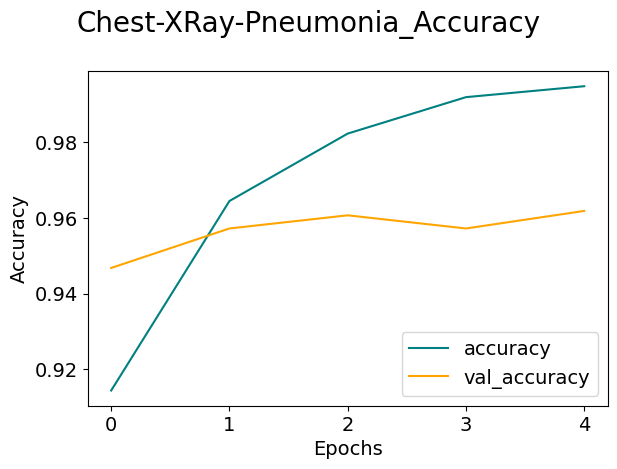

Saved accuracies to /kaggle/working/figures/Chest-XRay-Pneumonia_accuracies.png


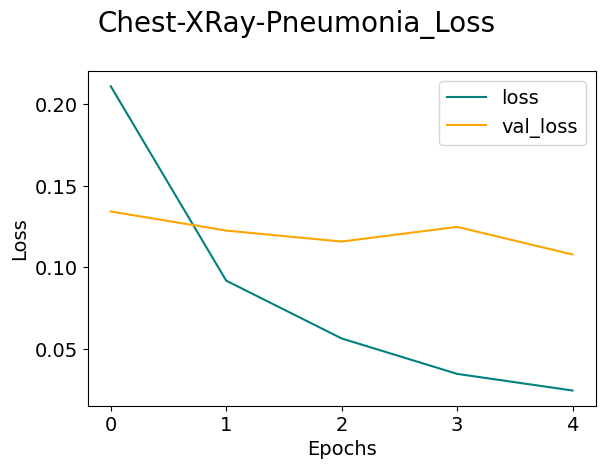

Saved losses to /kaggle/working/figures/Chest-XRay-Pneumonia_losses.png


In [40]:
plot_accuracies(history)
plot_losses(history)

### Evaluate Model

In [41]:
# model_path = os.path.join(models_dir, sorted_models[9])
model_path = '/kaggle/working/models/Chest-XRay-Pneumonia_iv3_modelepoch_05 acc_0.9947 loss_0.0244 val_acc_0.9618 val_loss_0.1078.keras'

loaded_model = tf.keras.models.load_model(model_path)

print(loaded_model)
print(model_path)
print('Model Size: {:.2f} MB'.format(os.path.getsize(model_path) / (1024*1024)))

<Functional name=Chest-XRay-Pneumonia_iv3_model, built=True>
/kaggle/working/models/Chest-XRay-Pneumonia_iv3_modelepoch_05 acc_0.9947 loss_0.0244 val_acc_0.9618 val_loss_0.1078.keras
Model Size: 475.98 MB


In [42]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = loaded_model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    
print('Precision : {}'.format(pre.result().numpy()))
print('Recall : {}'.format(re.result().numpy()))   
print('Accuracy : {}'.format(acc.result().numpy())) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Precision : 0.9702970385551453
Recall : 0.9800000190734863
Accuracy : 0.9750000238418579


### Make predictions

In [43]:
print(class_labels)

{'normal': 0, 'pneumonia': 1}


In [44]:
val_0_dir = test_dir_1
val_1_dir = test_dir_2

print(val_0_dir,'\n')
print(val_1_dir)

/kaggle/working/test/normal 

/kaggle/working/test/pneumonia


In [45]:
file_paths_val_0 = [os.path.join(val_0_dir, filename) for filename in os.listdir(val_0_dir)]
file_paths_val_1 = [os.path.join(val_1_dir, filename) for filename in os.listdir(val_1_dir)]

class_0_test = random.choice(file_paths_val_0)
class_1_test = random.choice(file_paths_val_1)

# Get the class label from the file path
class_label_0 = class_0_test.split('/')[-2]
class_label_1 = class_1_test.split('/')[-2]

# Get the class label value (0 or 1) from the class_labels dictionary
class_value_0 = class_labels[class_label_0]
class_value_1 = class_labels[class_label_1]

print(class_0_test)
print(class_1_test)

/kaggle/working/test/normal/NORMAL2-IM-0424-0001.jpeg
/kaggle/working/test/pneumonia/person94_bacteria_457.jpeg


#### Class 0

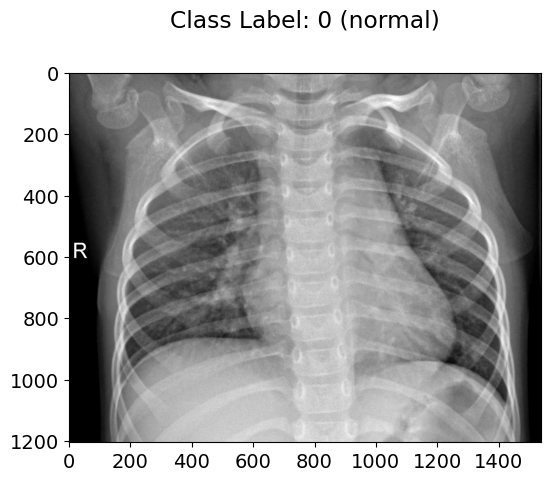

In [46]:
img = cv2.imread(class_0_test)
plt.imshow(img)
plt.title(f'Class Label: {class_value_0} ({class_label_0})', y=1.1)
plt.show()

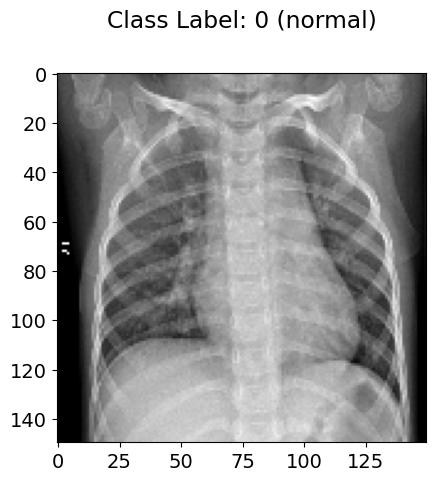

In [47]:
resize = tf.image.resize(img, (input_shape[0], input_shape[1]))
plt.title(f'Class Label: {class_value_0} ({class_label_0})',y=1.1)
plt.imshow(resize.numpy().astype(int))
plt.show()

In [48]:
prediction = loaded_model.predict(np.expand_dims(resize/255, 0))
predicted_class = np.round(prediction).astype(int)
print(f"Predicted class is {predicted_class} {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Predicted class is [[0]] [[0.00116001]]


#### Class 1

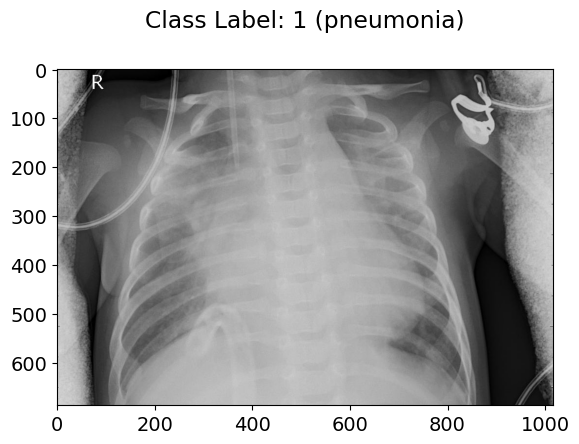

In [49]:
img = cv2.imread(class_1_test)
plt.imshow(img)
plt.title(f'Class Label: {class_value_1} ({class_label_1})',y=1.1)
plt.show()

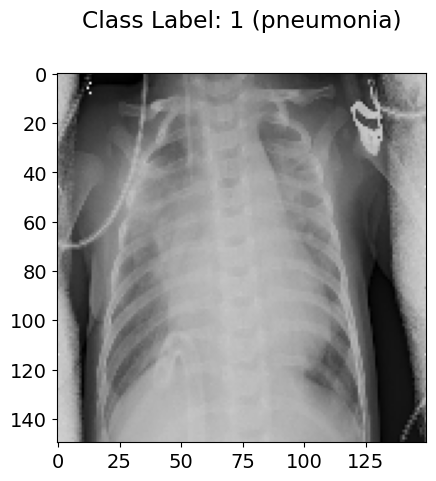

In [50]:
resize = tf.image.resize(img, (input_shape[0], input_shape[1]))
plt.imshow(resize.numpy().astype(int))
plt.title(f'Class Label: {class_value_1} ({class_label_1})', y=1.1)
plt.show()

In [51]:
prediction = loaded_model.predict(np.expand_dims(resize/255, 0))
predicted_class = np.round(prediction).astype(int)
print(f"Predicted class is {predicted_class} {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Predicted class is [[1]] [[0.9999954]]


### Batch Predictions and Evaluate using metrices

In [52]:
def process_and_predictions(folder,images, to_predict):
    predictions = []
    correct = []
    wrong = []
    for image in images:
        img = cv2.imread(os.path.join(folder, image))
        resize = tf.image.resize(img, (input_shape[0], input_shape[1]))
        prediction = loaded_model.predict(np.expand_dims(resize / 255, 0))
        predicted_class = np.round(prediction).astype(int)
        predictions.append(predicted_class)
        if predicted_class == to_predict:
            correct.append(os.path.join(folder, image))
        else:
            wrong.append(os.path.join(folder, image))
    return predictions,correct, wrong

In [53]:
%%capture %%time
predictions_0, correct_0, wrong_0 = process_and_predictions(val_0_dir,os.listdir(val_0_dir), 0)

In [54]:
%%capture %%time
predictions_1, correct_1, wrong_1 = process_and_predictions(val_1_dir,os.listdir(val_1_dir), 1)

In [55]:
print(len(predictions_0), type(predictions_0))
print(len(predictions_1), type(predictions_1))

100 <class 'list'>
100 <class 'list'>


In [56]:
print(class_labels)

{'normal': 0, 'pneumonia': 1}


In [57]:
no_of_correct_0 = len(correct_0)
no_of_correct_1 = len(correct_1)

no_of_wrong_0 = len(wrong_0)
no_of_wrong_1 = len(wrong_1)

total_0 = no_of_correct_0 + no_of_wrong_0
total_1 = no_of_correct_1 + no_of_wrong_1

percent_of_correct_0 = (no_of_correct_0 / total_0)*100
percent_of_correct_1 = (no_of_correct_1 / total_1)*100


print('Predictions for class_0 {}'.format(next(key for key, val in class_labels.items() if val == 0)))
print('Number of correct predictions : {} out of {}'.format(no_of_correct_0, total_0))
print('Number of wrong predictions : {}'.format(no_of_wrong_0, total_0))
print('Percentage of correct predictions : {}\n'.format(percent_of_correct_0))

print('Predictions for class_1 {}'.format(next(key for key, val in class_labels.items() if val == 1)))
print('Number of correct predictions : {} out of {}'.format(no_of_correct_1, total_1))
print('Number of wrong predictions : {}'.format(no_of_wrong_1, total_1))
print('Percentage of correct predictions : {}\n'.format(percent_of_correct_1))

Predictions for class_0 normal
Number of correct predictions : 97 out of 100
Number of wrong predictions : 3
Percentage of correct predictions : 97.0

Predictions for class_1 pneumonia
Number of correct predictions : 98 out of 100
Number of wrong predictions : 2
Percentage of correct predictions : 98.0



In [58]:
y_pred = predictions_0 + predictions_1
y_pred_flat = [int(prediction.flatten()[0]) for prediction in y_pred]
y_true = [0] * len(predictions_0) + [1] * len(predictions_1)

report = classification_report(y_true, y_pred_flat)

print(report)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       100
           1       0.97      0.98      0.98       100

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200



Image saved to /kaggle/working/figures/Chest-XRay-Pneumonia_Confusion Matrix.png


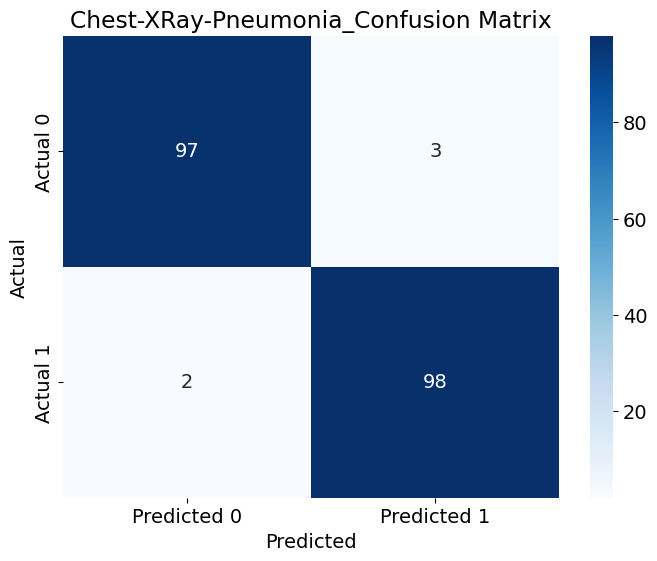

In [59]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_flat)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(project_name+'Confusion Matrix')
plt.savefig(os.path.join(figures_dir,project_name+'Confusion Matrix.png'))
print('Image saved to {}'.format(os.path.join(figures_dir,project_name+'Confusion Matrix.png')))
plt.show()

![Chest-XRay-Pneumonia_Confusion Matrix_1000_iv3.png](<attachment:Chest-XRay-Pneumonia_Confusion Matrix_1000_iv3.png>)

Using Inception V3
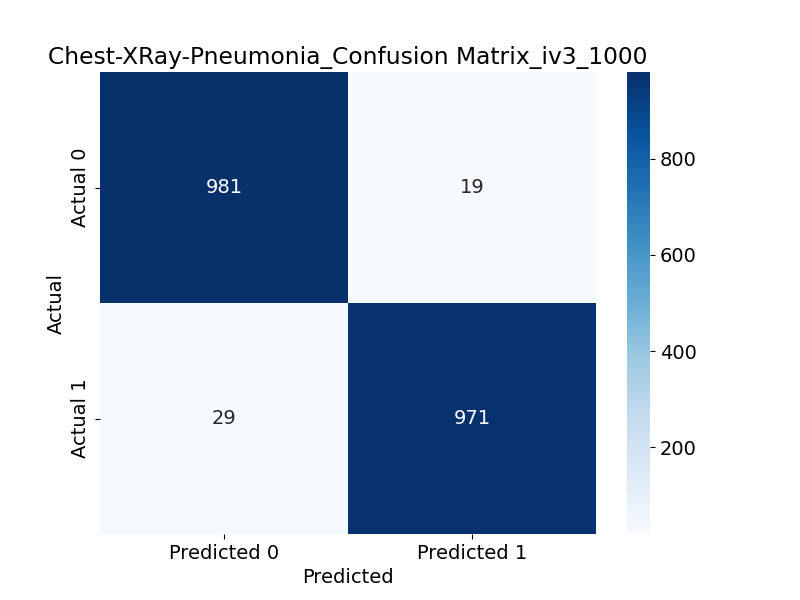

![Chest-XRay-Pneumonia_Confusion Matrix_1000.png](<attachment:Chest-XRay-Pneumonia_Confusion Matrix_1000.png>)

Using normal conv_2d model
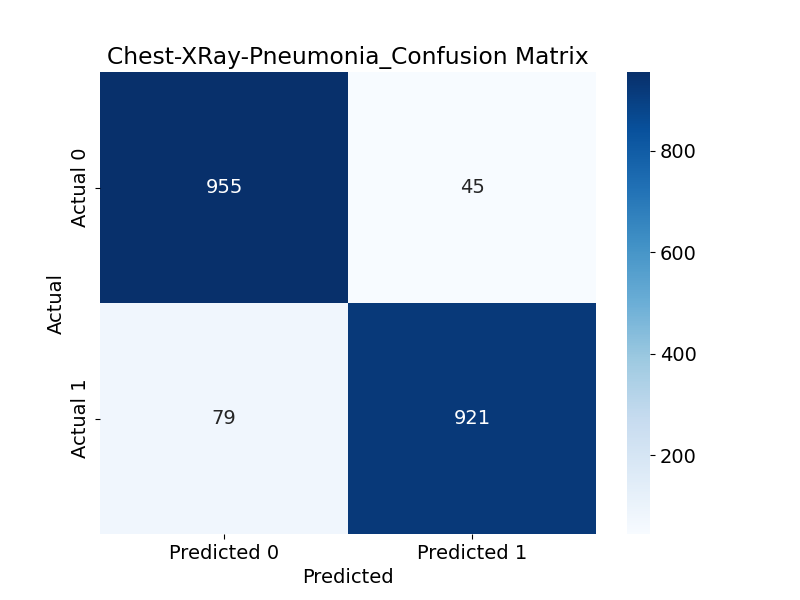

### Plot wrong predictions

### Actual-0, Predicted-1

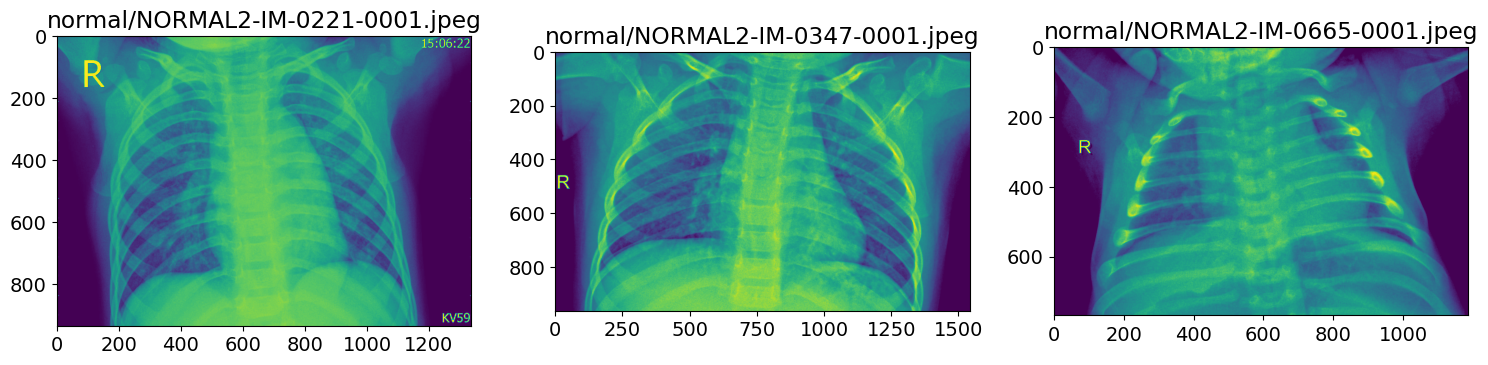

In [60]:
grid_plot(wrong_0[:24])

### Actual-1, Predicted-0

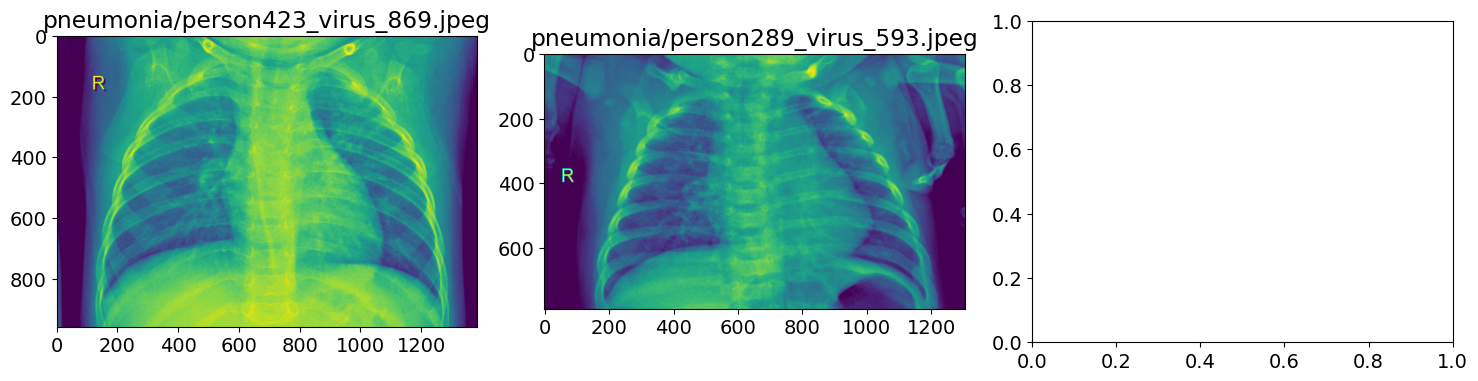

In [61]:
grid_plot(wrong_1[:24])

## Zip 

In [ ]:
# shutil.rmtree(project_name)

In [62]:
os.makedirs(project_name, exist_ok=True)

In [63]:
for folder in [models_dir, hist_dir, figures_dir]:
    files = get_file_paths(folder)
    project_files = [item for item in files if project_name in item]
    destination_folder = os.path.join(os.getcwd(), project_name,os.path.basename(folder))
    os.makedirs(destination_folder, exist_ok=True)
    [shutil.move(file_path, destination_folder) for file_path in project_files]
print('Files moved')

Files moved


In [66]:
for root_dir, dirs, files in os.walk(project_name):
    print(root_dir)
    print(files)
    print()

Chest-XRay-Pneumonia_
[]

Chest-XRay-Pneumonia_/figures
['Chest-XRay-Pneumonia_ Distribution of Images.png', 'Chest-XRay-Pneumonia_losses.png', 'Chest-XRay-Pneumonia_Confusion Matrix.png', 'Chest-XRay-Pneumonia_accuracies.png']

Chest-XRay-Pneumonia_/history
['Chest-XRay-Pneumonia_history.json']

Chest-XRay-Pneumonia_/models
['Chest-XRay-Pneumonia_iv3_modelepoch_05 acc_0.9947 loss_0.0244 val_acc_0.9618 val_loss_0.1078.keras']



In [65]:
# to_move = ['Chest-XRay-Pneumonia_iv3_modelepoch_03 acc_0.9822 loss_0.0563 val_acc_0.9606 val_loss_0.1157.keras', 'Chest-XRay-Pneumonia_iv3_modelepoch_01 acc_0.9144 loss_0.2110 val_acc_0.9468 val_loss_0.1342.keras', 'Chest-XRay-Pneumonia_iv3_modelepoch_02 acc_0.9644 loss_0.0918 val_acc_0.9572 val_loss_0.1225.keras']

# for file in to_move:
#     file_path = os.path.join(project_name+'/models', file)
#     shutil.move(file_path, models_dir)

In [68]:
size = get_directory_size(project_name)
convert_bytes(size)

'476.10 MB'

In [69]:
def create_zip():
    zip_path = os.path.join(zipfiles_dir,project_name)
    shutil.make_archive(zip_path, 'zip', project_name)
    print(os.listdir(zipfiles_dir))
    print(os.path.getsize(zip_path+'.zip')/(1024*1024) , ' MB')

In [70]:
create_zip()

['Chest-XRay-Pneumonia_.zip']
371.2098693847656  MB
